In [187]:
from statistics import median

import pandas as pd
import seaborn as sb
from IPython.terminal.shortcuts.filters import pass_through
from scipy.spatial.distance import euclidean
from seaborn import heatmap
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
from datetime import datetime


In [188]:
dat_orders = pd.read_csv("dataset/olist_orders_dataset.csv")
dat_order_items = pd.read_csv("dataset/olist_order_items_dataset.csv")
dat_products = pd.read_csv("dataset/olist_products_dataset.csv")
dat_sellers = pd.read_csv("dataset/olist_sellers_dataset.csv")

In [189]:
join_items = dat_orders.set_index("order_id").join(dat_order_items.set_index("order_id"), lsuffix="ord", rsuffix="itm", validate="many_to_many", how="inner")
join_products = join_items.set_index("product_id").join(dat_products.set_index("product_id"), lsuffix="itm", rsuffix="prd", validate="many_to_many", how="left")
join_sellers = join_products.set_index("seller_id").join(dat_sellers.set_index("seller_id"), lsuffix="itm", rsuffix="prd", validate="many_to_many", how="left")

In [190]:
from pandas import RangeIndex

data = join_sellers.drop(columns=["seller_zip_code_prefix", "product_photos_qty", "product_name_lenght", "product_description_lenght"]).reset_index(drop=False)

data = pd.DataFrame(data=data, columns=data.columns, index=RangeIndex(1, len(data) + 1, name='Index'))

data.head()

,seller_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,shipping_limit_date,price,freight_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_city,seller_state
Index,,,,,,,,,,,,,,,,,,,
1,289cdb325fb7e7f891c38608bf9e0962,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,2018-07-30 03:24:27,118.7,22.76,perfumaria,400.0,19.0,13.0,19.0,belo horizonte,SP
2,4869f7a5dfa277a7dca6462dcf3b52b2,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,2018-08-13 08:55:23,159.9,19.22,automotivo,420.0,24.0,19.0,21.0,guariba,SP
3,66922902710d126a0e7d26b0e3805106,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1.0,2017-11-23 19:45:59,45.0,27.20,pet_shop,450.0,30.0,10.0,20.0,belo horizonte,MG
4,2c9e548be18521d1c43cde1c582c6de8,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,2018-02-19 20:31:37,19.9,8.72,papelaria,250.0,51.0,15.0,15.0,mogi das cruzes,SP
5,8581055ce74af1daba164fdbd55a40de,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00,1.0,2017-07-13 22:10:13,147.9,27.36,automotivo,7150.0,65.0,10.0,65.0,guarulhos,SP


In [191]:
DATE_FIELDS = ['order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'shipping_limit_date']


In [192]:
FORMAT = "%Y-%m-%d %H:%M:%S"

for date_field in DATE_FIELDS:
    data[date_field] = data[date_field].apply(lambda dt: str(datetime.strptime(dt, FORMAT).toordinal() if pd.notna(dt) else np.nan))


In [193]:
data.order_approved_at.hasnans

False

<Axes: ylabel='Index'>

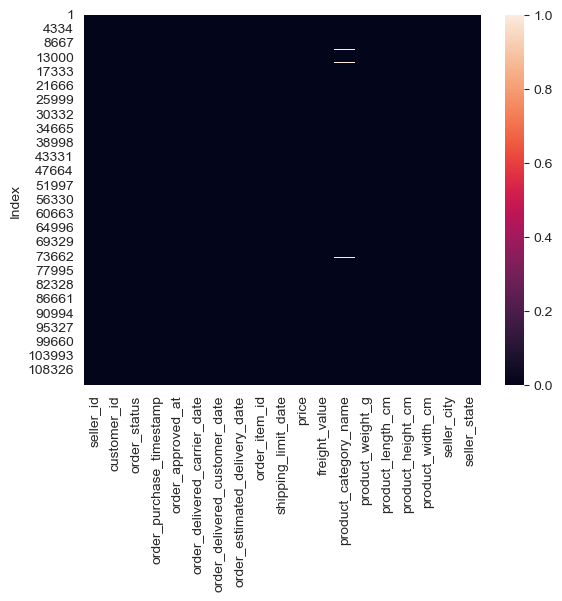

In [194]:
sb.heatmap(data.isna())

<Axes: >

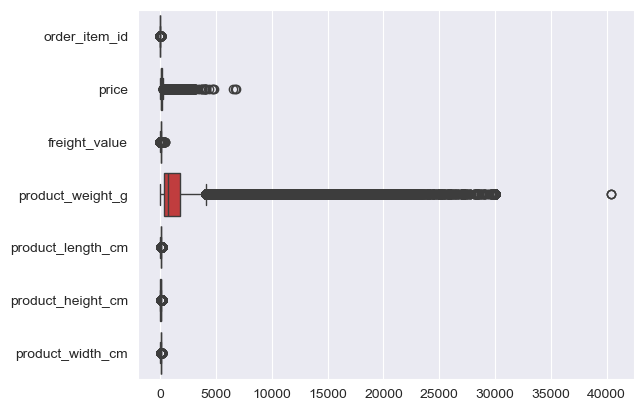

In [201]:
sb.boxplot(data, orient='h')

In [196]:
# Definição de features

ONE_HOT_FEATURES = ['order_status', 'product_category_name', 'seller_city', 'seller_state', 'customer_id', 'order_item_id']

KNN_FEATURES = DATE_FIELDS

SIMPLE_IMPUTER_FEATURES = []

STANDARD_FEATURES = data.columns.difference(ONE_HOT_FEATURES
                                            .__add__(KNN_FEATURES)
                                            .__add__(SIMPLE_IMPUTER_FEATURES))

In [220]:
TARGET = ['order_approved_at']
# TARGET = [].__add__(KNN_FEATURES).__add__(SIMPLE_IMPUTER_FEATURES).__add__(ONE_HOT_FEATURES)

x = data.drop(columns=TARGET)
y = data[TARGET]

In [226]:
x_train, x_test, y_train, y_test = train_test_split(x, y.loc[:1], test_size=0.3, stratify=y.loc[:1], random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [112650, 1]

In [213]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import RobustScaler
import sklearn
from sklearn.impute import KNNImputer

# Definição Pipelines
sklearn.set_config(enable_metadata_routing=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('simple_imputer', SimpleImputer()),
        ('knn_imputer', KNNImputer(metric='nan_euclidean')),
        ('onehotencoder', OneHotEncoder()),
        ('standardscale', StandardScaler())
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[('preprocessors', preprocessor)])

pipeline.fit(X=x_train, y=y_train)


TypeError: Pipeline.fit got unexpected argument(s) {'prefer_skip_nested_validation'}, which are not routed to any object.